In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve

from f_detrend import detrend_fuction

sn.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [15]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,colnames=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if colnames!=None:
                colanmes= colnames
            elif colnames==None and endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table

In [3]:
dates = []
for year in range(1987,2023):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

In [84]:
tab_b_moms10_p = read_table("./regtabs/bootstrap/boot_perm_w_3040_10_trial_svy.log",keyword='c.permanent@ciclo',
               ncols=4,end_row='201',colnames=['Mean', 'std', 'lower','upper'])
tab_b_moms10_p['dates'] = tab_b_moms10_p.index.map(date_dict)
# tab_b_moms10_p.rename(index=date_dict,inplace=True)

tab_b_no_moms_p = read_table("./regtabs/bootstrap/boot_perm_w_3040_10_trial_0k_svy.log",keyword='c.permanent@ciclo',
               ncols=4,end_row='201',colnames=['Mean', 'std', 'lower','upper'])
tab_b_no_moms_p['dates'] = tab_b_no_moms_p.index.map(date_dict)
# tab_b_no_moms_p.rename(index=date_dict,inplace=True)

tab_b_singlew_p = read_table("./regtabs/bootstrap/boot_perm_w_3040_10_trial_single_svy.log",keyword='c.permanent@ciclo',
               ncols=4,end_row='201',colnames=['Mean', 'std', 'lower','upper'])
tab_b_singlew_p['dates'] = tab_b_singlew_p.index.map(date_dict)
# tab_b_singlew_p.rename(index=date_dict,inplace=True)

tab_b_moms10_p.head()

,Mean,std,lower,upper,dates
130,0.324018,0.007701,0.308923,0.339112,2005Q1
131,0.322550,0.007690,0.307478,0.337621,2005Q2
132,0.334318,0.007818,0.318995,0.349642,2005Q3
133,0.335286,0.007710,0.320176,0.350397,2005Q4
134,0.334460,0.007365,0.320025,0.348895,2006Q1


In [85]:
tab_b_dads10_p = read_table("./regtabs/bootstrap/boot_perm_m_3040_10_trial_svy.log",keyword='c.permanent@ciclo',
               ncols=4,end_row='201',colnames=['Mean', 'std', 'lower','upper'])
tab_b_dads10_p['dates'] = tab_b_dads10_p.index.map(date_dict)
# tab_b_dads10_p.rename(index=date_dict,inplace=True)

tab_b_no_dads_p = read_table("./regtabs/bootstrap/boot_perm_m_3040_10_trial_0k_svy.log",keyword='c.permanent@ciclo',
               ncols=4,end_row='201',colnames=['Mean', 'std', 'lower','upper'])
tab_b_no_dads_p['dates'] = tab_b_no_dads_p.index.map(date_dict)
# tab_b_no_dads_p.rename(index=date_dict,inplace=True)

tab_b_singlem_p = read_table("./regtabs/bootstrap/boot_perm_m_3040_10_trial_single_svy.log",keyword='c.permanent@ciclo',
               ncols=4,end_row='201',colnames=['Mean', 'std', 'lower','upper'])
# tab_b_singlem_p['dates'] = tab_b_singlem_p.index.map(date_dict)
tab_b_singlem_p.rename(index=date_dict,inplace=True)

tab_b_dads10_p.head()

,Mean,std,lower,upper,dates
130,0.572223,0.009011,0.554562,0.589885,2005Q1
131,0.565213,0.009046,0.547483,0.582943,2005Q2
132,0.560701,0.009098,0.542870,0.578532,2005Q3
133,0.555189,0.009121,0.537312,0.573066,2005Q4
134,0.546320,0.008767,0.529136,0.563504,2006Q1


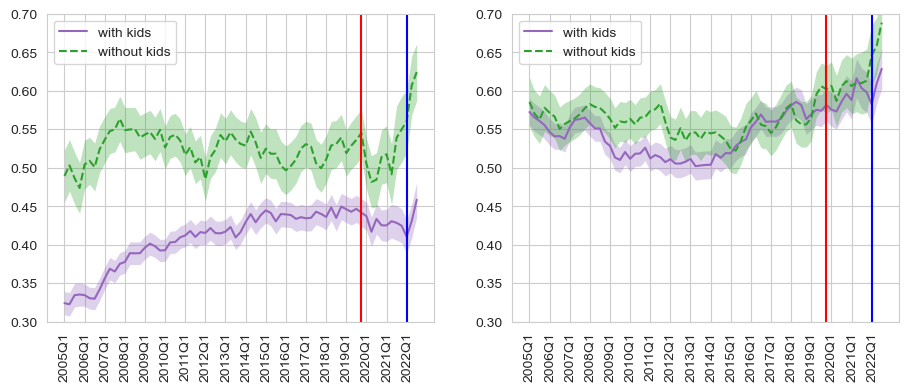

In [72]:
colors = sn.color_palette()
t0 = date_dict_reverse_ciclo['2005Q1']
t00 = date_dict_reverse_ciclo['2019Q4']-t0
T=  date_dict_reverse_ciclo['2022Q4']-t0
T = tab_b_moms10_p.index[t0:].size-1

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(tab_b_moms10_p['Mean'],c=colors[4],label='with kids')
plt.fill_between(tab_b_moms10_p.index,tab_b_moms10_p['lower'],tab_b_moms10_p['upper'], color=colors[4], alpha=0.3, lw=0)

plt.plot(tab_b_no_moms_p['Mean'],c=colors[2],ls="--",label='without kids')
plt.fill_between(tab_b_no_moms_p.index,tab_b_no_moms_p['lower'],tab_b_no_moms_p['upper'], color=colors[2], alpha=0.3, lw=0)

# plt.plot(tab_b_singlew_p['Mean'],c=colors[0],ls=":",label='without kids')
# plt.fill_between(tab_b_singlew_p.index,tab_b_singlew_p['lower'],tab_b_singlew_p['upper'], color=colors[0], alpha=0.3, lw=0)


plt.xticks(tab_b_moms10_p.index[::4],rotation=90)
plt.axvline('2019Q4',c='r')
plt.axvline('2022Q1',c='b')
# plt.xlim(0,T)
plt.legend()
plt.ylim(0.3,0.7)

plt.subplot(122)
plt.plot(tab_b_dads10_p['Mean'],c=colors[4],label='with kids')
plt.fill_between(tab_b_dads10_p.index,tab_b_dads10_p['lower'],tab_b_dads10_p['upper'], color=colors[4], alpha=0.3, lw=0)

plt.plot(tab_b_no_dads_p['Mean'],c=colors[2],ls="--",label='without kids')
plt.fill_between(tab_b_no_dads_p.index,tab_b_no_dads_p['lower'],tab_b_no_dads_p['upper'], color=colors[2], alpha=0.3, lw=0)

# plt.plot(tab_b_singlem_p['Mean'],c=colors[0],ls=":",label='without kids')
# plt.fill_between(tab_b_singlem_p.index,tab_b_singlem_p['lower'],tab_b_singlem_p['upper'], color=colors[0], alpha=0.3, lw=0)

plt.xticks(tab_b_dads10_p.index[::4],rotation=90)
plt.axvline('2019Q4',c='r')
plt.axvline('2022Q1',c='b')
# plt.xlim(0,T)
plt.legend()
plt.ylim(0.3,0.7)

plt.show()

In [165]:
tab_b0_moms10_p = read_table("./regtabs/bootstrap/boot_perm_w_3040_10_trial.log",keyword='c.permanent@ciclo',
               ncols=4,end_row='201',colnames=['Mean', 'std', 'lower','upper'])
tab_b0_moms10_p['dates'] = tab_b0_moms10_p.index.map(date_dict)
# tab_b0_moms10_p.rename(index=date_dict,inplace=True)

tab_b0_no_moms_p = read_table("./regtabs/bootstrap/boot_perm_w_3040_10_trial_0k.log",keyword='c.permanent@ciclo',
               ncols=4,end_row='201',colnames=['Mean', 'std', 'lower','upper'])
tab_b0_no_moms_p['dates'] = tab_b0_no_moms_p.index.map(date_dict)
# tab_b0_no_moms_p.rename(index=date_dict,inplace=True)

tab_b0_dads10_p = read_table("./regtabs/bootstrap/boot_perm_m_3040_10_trial.log",keyword='c.permanent@ciclo',
               ncols=4,end_row='201',colnames=['Mean', 'std', 'lower','upper'])
tab_b0_dads10_p['dates'] = tab_b0_dads10_p.index.map(date_dict)
# tab_b0_dads10_p.rename(index=date_dict,inplace=True)

tab_b0_no_dads_p = read_table("./regtabs/bootstrap/boot_perm_m_3040_10_trial_0k.log",keyword='c.permanent@ciclo',
               ncols=4,end_row='201',colnames=['Mean', 'std', 'lower','upper'])
tab_b0_no_dads_p['dates'] = tab_b0_no_dads_p.index.map(date_dict)
# tab_b0_no_dads_p.rename(index=date_dict,inplace=True)

tab_b0_moms10_p.head()

,Mean,std,lower,upper,dates
130,0.309122,0.005525,0.298293,0.319951,2005Q1
131,0.308380,0.005521,0.297559,0.319202,2005Q2
132,0.317825,0.006230,0.305613,0.330036,2005Q3
133,0.326429,0.005371,0.315903,0.336955,2005Q4
134,0.324685,0.006389,0.312164,0.337207,2006Q1


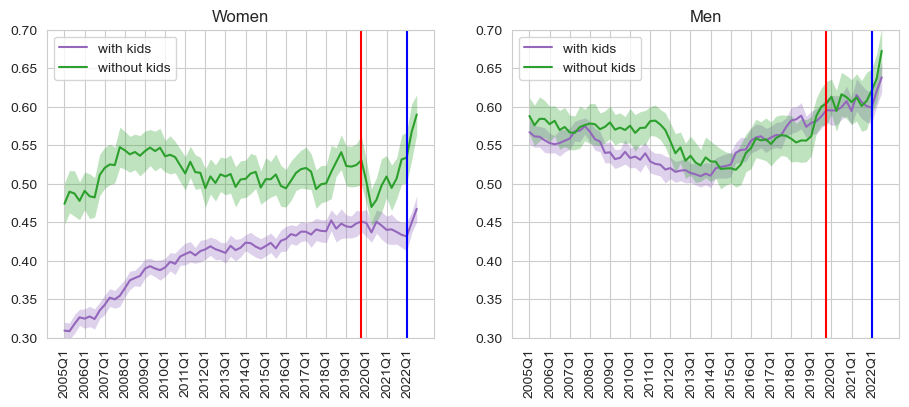

In [173]:
colors = sn.color_palette()
t0 = date_dict_reverse_ciclo['2005Q1']
t00 = date_dict_reverse_ciclo['2019Q4']-t0
T=  date_dict_reverse_ciclo['2022Q4']-t0
T = tab_b0_moms10_p.index[t0:].size-1

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title('Women')
plt.plot(tab_b0_no_moms_p['dates'],tab_b0_moms10_p['Mean'],c=colors[4],label='with kids')
plt.fill_between(tab_b0_no_moms_p['dates'],tab_b0_moms10_p['lower'],tab_b0_moms10_p['upper'], color=colors[4], alpha=0.3, lw=0)

plt.plot(tab_b0_no_moms_p['dates'],tab_b0_no_moms_p['Mean'],c=colors[2],label='without kids')
plt.fill_between(tab_b0_no_moms_p['dates'],tab_b0_no_moms_p['lower'],tab_b0_no_moms_p['upper'], color=colors[2], alpha=0.3, lw=0)

plt.xticks(tab_b0_no_moms_p['dates'][::4],rotation=90)
plt.axvline('2019Q4',c='r')
plt.axvline('2022Q1',c='b')
# plt.xlim(0,T)
plt.ylim(0.3,0.7)
plt.legend()

plt.subplot(122)
plt.title('Men')
plt.plot(tab_b0_no_moms_p['dates'],tab_b0_dads10_p['Mean'],c=colors[4],label='with kids')
plt.fill_between(tab_b0_no_moms_p['dates'],tab_b0_dads10_p['lower'],tab_b0_dads10_p['upper'], color=colors[4], alpha=0.3, lw=0)

plt.plot(tab_b0_no_moms_p['dates'],tab_b0_no_dads_p['Mean'],c=colors[2],label='without kids')
plt.fill_between(tab_b0_no_moms_p['dates'],tab_b0_no_dads_p['lower'],tab_b0_no_dads_p['upper'], color=colors[2], alpha=0.3, lw=0)

plt.xticks(tab_b0_no_moms_p['dates'][::4],rotation=90)
plt.axvline('2019Q4',c='r')
plt.axvline('2022Q1',c='b')
# plt.xlim(0,T)
plt.legend()
plt.ylim(0.3,0.7)
plt.show()

### Detrending

In [228]:
date_cuts_20_m = np.vstack((['2016Q1',],['2022Q4',]))
t0 = date_dict_reverse_ciclo[date_cuts_20_m[0].item()]
states = ['E','P','T','U','I']

stocks_mothers_detrend = {}
stocks_fathers_detrend = {}

trend, predict = detrend_fuction(tab_b0_moms10_p,'Mean',date_cuts_20_m,date0='2019Q4',dateT='2023Q1',
                                 date_dict=date_dict_reverse_ciclo,extended=False)
stocks_mothers_detrend['P'] = tab_b0_moms10_p['Mean'].loc[t0:] - predict

trend_up, predict_up = detrend_fuction(tab_b0_moms10_p,'upper',date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                 date_dict=date_dict_reverse_ciclo,extended=False)
stocks_mothers_detrend['P_up'] = tab_b0_moms10_p['upper'].loc[t0:] - predict_up

trend_dwn, predict_dwn = detrend_fuction(tab_b0_moms10_p,'lower',date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                 date_dict=date_dict_reverse_ciclo,extended=False)
stocks_mothers_detrend['P_down'] = tab_b0_moms10_p['lower'].loc[t0:] - predict_dwn

trend, predict = detrend_fuction(tab_b0_dads10_p,'Mean',date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                 date_dict=date_dict_reverse_ciclo,extended=False)
stocks_fathers_detrend['P'] = tab_b0_dads10_p['Mean'].loc[t0:] - predict
    
stocks_not_mothers_detrend = {}
stocks_not_fathers_detrend = {}

trend, predict = detrend_fuction(tab_b0_no_moms_p,'Mean',date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                 date_dict=date_dict_reverse_ciclo,extended=False)
stocks_not_mothers_detrend['P'] = tab_b0_no_moms_p['Mean'].loc[t0:] - predict

trend_dwn, predict_dwn = detrend_fuction(tab_b0_no_moms_p,'lower',date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                 date_dict=date_dict_reverse_ciclo,extended=False)
stocks_not_mothers_detrend['P_down'] = tab_b0_no_moms_p['lower'].loc[t0:] - predict_dwn

trend_up, predict_up = detrend_fuction(tab_b0_no_moms_p,'upper',date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                 date_dict=date_dict_reverse_ciclo,extended=False)
stocks_not_mothers_detrend['P_up'] = tab_b0_no_moms_p['upper'].loc[t0:] - predict_up

# Men

trend, predict= detrend_fuction(tab_b0_no_dads_p,'Mean',date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                date_dict=date_dict_reverse_ciclo,extended=False)
stocks_not_fathers_detrend['P'] = tab_b0_no_dads_p['Mean'].loc[t0:] - predict

trend_dwn, predict_dwn = detrend_fuction(tab_b0_dads10_p,'lower',date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                 date_dict=date_dict_reverse_ciclo,extended=False)
stocks_fathers_detrend['P_down'] = tab_b0_dads10_p['lower'].loc[t0:] - predict_dwn

trend, predict = detrend_fuction(tab_b0_dads10_p,'Mean',date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                 date_dict=date_dict_reverse_ciclo,extended=False)
stocks_fathers_detrend['P'] = tab_b0_dads10_p['Mean'].loc[t0:] - predict

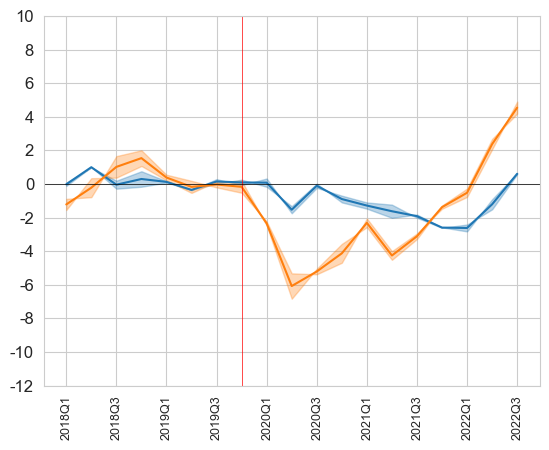

In [175]:
t0 = date_dict_reverse_ciclo['2018Q1']
t19 = date_dict_reverse_ciclo['2019Q1']
t20 = date_dict_reverse_ciclo['2019Q4']
t00 = t0 - date_dict_reverse_ciclo['2016Q1']
T = date_dict_reverse_ciclo['2021Q4']-t0

dt_boom = T - (date_dict_reverse_ciclo['2021Q4']-date_dict_reverse_ciclo['2019Q4'])
dt_bot = T - (date_dict_reverse_ciclo['2021Q4']-date_dict_reverse_ciclo['2020Q2'])
colors = sn.color_palette()

dev_trend_moms = stocks_mothers_detrend['P'].loc[t0:]-np.average(stocks_mothers_detrend['P'].loc[t19:t20])    
dev_trend_moms_up = stocks_mothers_detrend['P_up'].loc[t0:]-np.average(stocks_mothers_detrend['P_up'].loc[t19:t20])  
dev_trend_moms_down = stocks_mothers_detrend['P_down'].loc[t0:]-np.average(stocks_mothers_detrend['P_down'].loc[t19:t20])  
plt.plot(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_moms,label='With children',color=colors[0])
plt.fill_between(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_moms_up,dev_trend_moms_down,color=colors[0],alpha=0.3)

dev_trend_no_moms = stocks_not_mothers_detrend['P'].loc[t0:]-np.average(stocks_not_mothers_detrend['P'].loc[t19:t20])    
dev_trend_no_moms_up = stocks_not_mothers_detrend['P_up'].loc[t0:]-np.average(stocks_not_mothers_detrend['P_up'].loc[t19:t20])  
dev_trend_no_moms_down = stocks_not_mothers_detrend['P_down'].loc[t0:]-np.average(stocks_not_mothers_detrend['P_down'].loc[t19:t20])  
plt.plot(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_no_moms,label='With children',color=colors[1])
plt.fill_between(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_no_moms_up,dev_trend_no_moms_down,color=colors[1],alpha=0.3)

plt.yticks(np.arange(-0.12,0.12,0.02),np.arange(-12,12,2),fontsize=12)
plt.xticks(tab_b_no_moms_p['dates'].loc[t0::2],rotation=90,fontsize=9)
plt.axvline(dt_boom,c='r',lw=0.5)
plt.axhline(c='k',lw=0.5)
plt.show()

In [ ]:



labels = ['Employment','Permanent Employment','Temporary Employment','Unemployment','Inactivity','Self-Employment']
labels_st = ['Mothers','Fathers']
# lims = [(-120000,60000),(-60000,140000),(-175000,25000),(-25000,150000)]

plt.figure(figsize=(14,4))
    
for j,s in enumerate(states):
    plt.subplot(1,5,(j+1))
    plt.title(labels[j],fontsize=14)
    
    dev_trend_moms = stocks_mothers_detrend[s].loc[t0:]-np.average(stocks_mothers_detrend[s].loc[t19:t20])    
    plt.plot(stocks_mothers['dates'].loc[t0:],dev_trend_moms,label='With children',c=colors[0])
    
    dev_trend_0k = stocks_not_mothers_detrend[s].loc[t0:]-np.average(stocks_not_mothers_detrend[s].loc[t19:t20]) 
    plt.plot(stocks_not_mothers['dates'].loc[t0:],dev_trend_0k,label='Without children',c=colors[1])
    
    dev_trend_s = stocks_single_women_detrend[s].loc[t0:]-np.average(stocks_single_women_detrend[s].loc[t19:t20]) 
    plt.plot(stocks_single_women['dates'].loc[t0:],dev_trend_s,label='Single',c=colors[1],ls='--')
    
    plt.yticks(np.arange(-0.12,0.12,0.02),np.arange(-12,12,2),fontsize=12)
    plt.xticks(stocks_single_women['dates'].loc[t0::2],rotation=90,fontsize=9)
    plt.axvline(dt_boom,c='r',lw=0.5)
    plt.axhline(c='k',lw=0.5)
    if j==3:
        plt.legend(loc='lower right',fontsize=12)

plt.tight_layout()
# plt.savefig('./plots_stocks/spain_stocks_detrend_mothers_extended.pdf',format='pdf',bbox_inches='tight')
plt.show()

### Proper bootstrap simulation

In [261]:
data_bb = pd.read_stata("./regtabs/bootstrap/boot_perm_w_3040_10_trial_130.dta").rename(columns={'mean':130})
for i in range(130,202):
    data_i = pd.read_stata("./regtabs/bootstrap/boot_perm_w_3040_10_trial_{}.dta".format(i)).rename(columns={'mean':i})
    data_bb = pd.concat((data_bb,data_i),axis=1)
data_bb = data_bb.T
newcols = [ "r_" + str(x) for x in range(1, 101) ]
data_bb.rename(columns=dict(zip(np.arange(1000,dtype=int),newcols)),inplace=True)

data_bb_0k = pd.read_stata("./regtabs/bootstrap/boot_perm_w_3040_10_trial_0k_130.dta").rename(columns={'mean':130})
for i in range(130,202):
    data_i = pd.read_stata("./regtabs/bootstrap/boot_perm_w_3040_10_trial_0k_{}.dta".format(i)).rename(columns={'mean':i})
    data_bb_0k = pd.concat((data_bb_0k,data_i),axis=1)
data_bb_0k = data_bb_0k.T
newcols = [ "r_" + str(x) for x in range(1, 101) ]
data_bb_0k.rename(columns=dict(zip(np.arange(1000,dtype=int),newcols)),inplace=True)

In [262]:
data_bb_m = pd.read_stata("./regtabs/bootstrap/boot_perm_m_3040_10_trial_130.dta").rename(columns={'mean':130})
for i in range(130,202):
    data_i = pd.read_stata("./regtabs/bootstrap/boot_perm_m_3040_10_trial_{}.dta".format(i)).rename(columns={'mean':i})
    data_bb_m = pd.concat((data_bb_m,data_i),axis=1)
data_bb_m = data_bb_m.T
newcols = [ "r_" + str(x) for x in range(1, 101) ]
data_bb_m.rename(columns=dict(zip(np.arange(1000,dtype=int),newcols)),inplace=True)

data_bb_m_0k = pd.read_stata("./regtabs/bootstrap/boot_perm_m_3040_10_trial_0k_130.dta").rename(columns={'mean':130})
for i in range(130,202):
    data_i = pd.read_stata("./regtabs/bootstrap/boot_perm_m_3040_10_trial_0k_{}.dta".format(i)).rename(columns={'mean':i})
    data_bb_m_0k = pd.concat((data_bb_m_0k,data_i),axis=1)
data_bb_m_0k = data_bb_m_0k.T
newcols = [ "r_" + str(x) for x in range(1, 101) ]
data_bb_m_0k.rename(columns=dict(zip(np.arange(1000,dtype=int),newcols)),inplace=True)

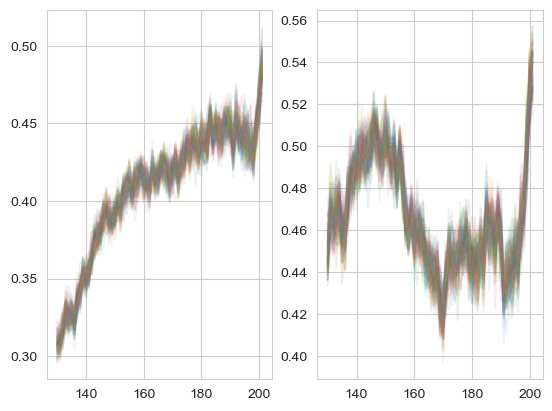

In [263]:
plt.subplot(121)
for i in newcols:
    plt.plot(data_bb[i],alpha=0.1)
    
plt.subplot(122)
for i in newcols:
    plt.plot(data_bb_0k[i],alpha=0.1)
    
plt.show()

Detrending

In [264]:
data_bb['dates'] = data_bb.index.map(date_dict)
data_bb_0k['dates'] = data_bb_0k.index.map(date_dict)
stocks_mothers_detrend_bb,stocks_mothers_detrend_bb_0k = {}, {}
RR = data_bb.keys().size

date_cuts_20_m = np.vstack((['2016Q1',],['2022Q4',]))
t0 = date_dict_reverse_ciclo[date_cuts_20_m[0].item()]

for j in newcols:
#     print(j)
    trend, predict = detrend_fuction(data_bb,j,date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                     date_dict=date_dict_reverse_ciclo,extended=False)
    stocks_mothers_detrend_bb[j] = data_bb[j].loc[t0:] - predict
    
    trend, predict = detrend_fuction(data_bb_0k,j,date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                     date_dict=date_dict_reverse_ciclo,extended=False)
    stocks_mothers_detrend_bb_0k[j] = data_bb_0k[j].loc[t0:] - predict

dev_data = pd.DataFrame(stocks_mothers_detrend_bb)
dev_data_0k = pd.DataFrame(stocks_mothers_detrend_bb_0k)

In [265]:
data_bb_m['dates'] = data_bb_m.index.map(date_dict)
data_bb_m_0k['dates'] = data_bb_m_0k.index.map(date_dict)
stocks_mothers_detrend_bb_m,stocks_mothers_detrend_bb_m_0k = {}, {}
RR = data_bb_m.keys().size

date_cuts_20_m = np.vstack((['2016Q1',],['2022Q4',]))
t0 = date_dict_reverse_ciclo[date_cuts_20_m[0].item()]

for j in newcols:
#     print(j)
    trend, predict = detrend_fuction(data_bb_m,j,date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                     date_dict=date_dict_reverse_ciclo,extended=False)
    stocks_mothers_detrend_bb_m[j] = data_bb_m[j].loc[t0:] - predict
    
    trend, predict = detrend_fuction(data_bb_m_0k,j,date_cuts_20_m,date0='2019Q4',dateT='2022Q4',
                                     date_dict=date_dict_reverse_ciclo,extended=False)
    stocks_mothers_detrend_bb_m_0k[j] = data_bb_m_0k[j].loc[t0:] - predict

dev_data_m = pd.DataFrame(stocks_mothers_detrend_bb_m)
dev_data_m_0k = pd.DataFrame(stocks_mothers_detrend_bb_m_0k)

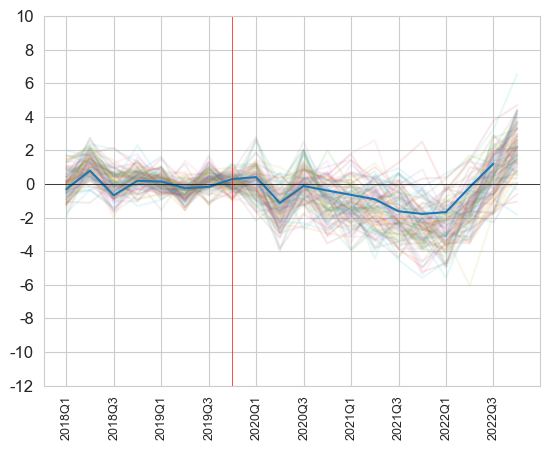

In [266]:
t0 = date_dict_reverse_ciclo['2018Q1']
t19 = date_dict_reverse_ciclo['2019Q1']
t20 = date_dict_reverse_ciclo['2019Q4']
t00 = t0 - date_dict_reverse_ciclo['2016Q1']
T = date_dict_reverse_ciclo['2021Q4']-t0

std = np.std(dev_data,axis=1)
dt_boom = T - (date_dict_reverse_ciclo['2021Q4']-date_dict_reverse_ciclo['2019Q4'])
dt_bot = T - (date_dict_reverse_ciclo['2021Q4']-date_dict_reverse_ciclo['2020Q2'])
colors = sn.color_palette()
for j in newcols:
    dev_trend_moms = stocks_mothers_detrend_bb[j].loc[t0:]-np.average(stocks_mothers_detrend_bb[j].loc[t19:t20])    
    plt.plot(data_bb['dates'].loc[t0:],dev_trend_moms,alpha=0.1)
    
dev_trend_moms = stocks_mothers_detrend['P'].loc[t0:]-np.average(stocks_mothers_detrend['P'].loc[t19:t20])    
plt.plot(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_moms,label='With children',color=colors[0])

plt.yticks(np.arange(-0.12,0.12,0.02),np.arange(-12,12,2),fontsize=12)
plt.xticks(tab_b_no_moms_p['dates'].loc[t0::2],rotation=90,fontsize=9)
plt.axvline(dt_boom,c='r',lw=0.5)
plt.axhline(c='k',lw=0.5)
plt.show()

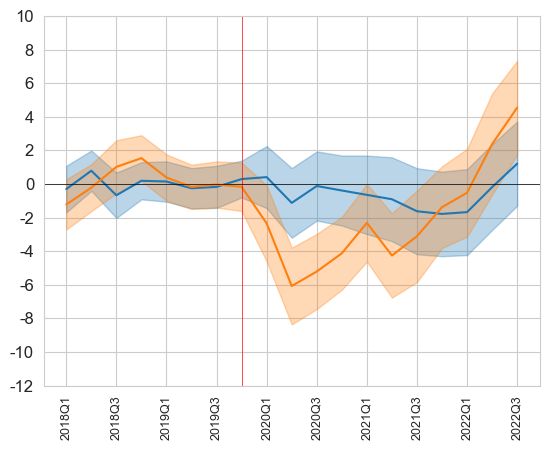

In [267]:
t0 = date_dict_reverse_ciclo['2018Q1']
t19 = date_dict_reverse_ciclo['2019Q1']
t20 = date_dict_reverse_ciclo['2019Q4']
t00 = t0 - date_dict_reverse_ciclo['2016Q1']
T = date_dict_reverse_ciclo['2021Q4']-t0

std = np.std(dev_data.loc[t0:],axis=1)
std_0k = np.std(dev_data_0k.loc[t0:],axis=1)
    
dev_trend_moms = stocks_mothers_detrend['P'].loc[t0:]-np.average(stocks_mothers_detrend['P'].loc[t19:t20])    
plt.plot(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_moms,label='With children',color=colors[0])
plt.fill_between(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_moms+2*std[:-1],dev_trend_moms-2*std[:-1],color=colors[0],alpha=0.3)

dev_trend_moms_0k = stocks_not_mothers_detrend['P'].loc[t0:]-np.average(stocks_not_mothers_detrend['P'].loc[t19:t20])    
plt.plot(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_moms_0k,label='With children',color=colors[1])
plt.fill_between(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_moms_0k+2*std_0k[:-1]
                 ,dev_trend_moms_0k-2*std_0k[:-1],color=colors[1],alpha=0.3)

plt.yticks(np.arange(-0.12,0.12,0.02),np.arange(-12,12,2),fontsize=12)
plt.xticks(tab_b_no_moms_p['dates'].loc[t0::2],rotation=90,fontsize=9)
plt.axvline(dt_boom,c='r',lw=0.5)
plt.axhline(c='k',lw=0.5)
plt.show()

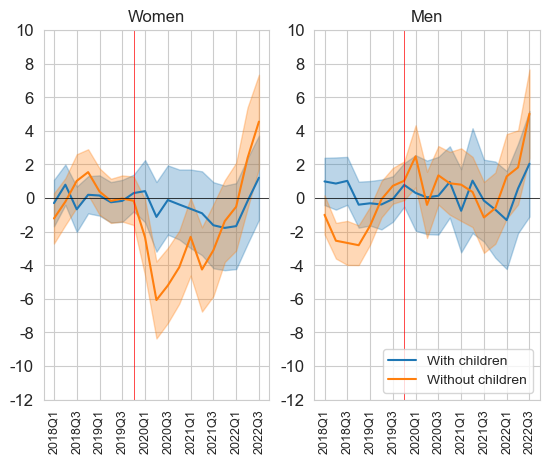

In [268]:
t0 = date_dict_reverse_ciclo['2018Q1']
t19 = date_dict_reverse_ciclo['2019Q1']
t20 = date_dict_reverse_ciclo['2019Q4']
t00 = t0 - date_dict_reverse_ciclo['2016Q1']
T = date_dict_reverse_ciclo['2021Q4']-t0

std_m = np.std(dev_data_m.loc[t0:],axis=1)
std_m_0k = np.std(dev_data_m_0k.loc[t0:],axis=1)
std = np.std(dev_data.loc[t0:],axis=1)
std_0k = np.std(dev_data_0k.loc[t0:],axis=1)
    
plt.subplot(121)
plt.title('Women')
dev_trend_moms = stocks_mothers_detrend['P'].loc[t0:]-np.average(stocks_mothers_detrend['P'].loc[t19:t20])    
plt.plot(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_moms,label='With children',color=colors[0])
plt.fill_between(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_moms+2*std[:-1],dev_trend_moms-2*std[:-1],color=colors[0],alpha=0.3)

dev_trend_moms_0k = stocks_not_mothers_detrend['P'].loc[t0:]-np.average(stocks_not_mothers_detrend['P'].loc[t19:t20])    
plt.plot(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_moms_0k,label='With children',color=colors[1])
plt.fill_between(tab_b_no_moms_p['dates'].loc[t0:],dev_trend_moms_0k+2*std_0k[:-1]
                 ,dev_trend_moms_0k-2*std_0k[:-1],color=colors[1],alpha=0.3)

plt.yticks(np.arange(-0.12,0.12,0.02),np.arange(-12,12,2),fontsize=12)
plt.xticks(tab_b_no_moms_p['dates'].loc[t0::2],rotation=90,fontsize=9)
plt.axvline(dt_boom,c='r',lw=0.5)
plt.axhline(c='k',lw=0.5)

plt.subplot(122)
plt.title('Men')
dev_trend_dads = stocks_fathers_detrend['P'].loc[t0:]-np.average(stocks_fathers_detrend['P'].loc[t19:t20])    
plt.plot(tab_b_no_dads_p['dates'].loc[t0:],dev_trend_dads,label='With children',color=colors[0])
plt.fill_between(tab_b_no_dads_p['dates'].loc[t0:],dev_trend_dads+2*std_m[:-1],
                 dev_trend_dads-2*std_m[:-1],color=colors[0],alpha=0.3)

dev_trend_dads_0k = stocks_not_fathers_detrend['P'].loc[t0:]-np.average(stocks_not_fathers_detrend['P'].loc[t19:t20])    
plt.plot(tab_b_no_dads_p['dates'].loc[t0:],dev_trend_dads_0k,label='Without children',color=colors[1])
plt.fill_between(tab_b_no_dads_p['dates'].loc[t0:],dev_trend_dads_0k+2*std_m_0k[:-1]
                 ,dev_trend_dads_0k-2*std_m_0k[:-1],color=colors[1],alpha=0.3)

plt.yticks(np.arange(-0.12,0.12,0.02),np.arange(-12,12,2),fontsize=12)
plt.xticks(tab_b_no_dads_p['dates'].loc[t0::2],rotation=90,fontsize=9)
plt.axvline(dt_boom,c='r',lw=0.5)
plt.axhline(c='k',lw=0.5)
plt.legend(loc='lower right')
plt.show()

In [182]:
dev_data = pd.DataFrame(stocks_mothers_detrend_bb)
dev_data.head()

,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,r_10,...,r_91,r_92,r_93,r_94,r_95,r_96,r_97,r_98,r_99,r_100
174,-0.000101,-0.002333,-0.012140,0.003390,-0.009867,-0.011867,-0.004504,0.009432,-0.006957,-0.005316,...,0.007928,0.002000,0.005548,-0.012281,-0.002127,0.009514,0.000556,-0.009860,-0.003615,-0.010122
175,0.003815,-0.001492,0.002851,-0.001540,0.002266,0.006940,-0.008918,-0.004070,0.014299,0.009858,...,-0.008612,-0.015212,0.004075,0.008226,-0.002396,-0.000844,-0.005978,0.001049,0.000457,0.001354
176,-0.007758,-0.004311,0.007995,-0.013276,0.001029,-0.006654,0.004249,-0.006523,-0.012361,-0.000869,...,-0.005528,-0.001682,0.002103,-0.001489,-0.002172,0.004224,0.008934,0.007456,-0.007651,0.012010
177,0.006589,-0.002710,0.001534,0.007366,0.006519,0.006905,-0.005235,0.010815,0.009091,0.003587,...,0.006231,0.011028,0.001190,0.009764,-0.000869,0.004289,0.003757,0.006059,0.001761,-0.000063
178,-0.004240,0.017587,0.012550,-0.007674,0.016812,0.002452,0.007329,-0.004535,-0.000226,-0.003210,...,0.002457,-0.003198,-0.019235,0.006756,0.007194,-0.001263,-0.001583,-0.003001,0.008066,-0.003962
